Correr en el ambiente de astropy creado con conda:

In [1]:
#Librerias

#Para cálculo numérico y simbólico
import numpy as np
import sympy as sp

#Para el manejo de datos
import pandas as pd

#Para gráficos
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Circle, Ellipse
import cartopy.crs as ccrs
import matplotlib.dates as mdates

#Para las constantes y unidades
import scipy.constants as sconst
import astropy.units as u
import astropy.constants as const

#Para las funciones especiales
import scipy.special as sps

#Para el manejo del tiempo
from astropy.time import Time
from datetime import datetime

#Para el manejo de las coordenadas
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

#Para extraer datos astronómicos (del Horizons del JPL de Nasa)
from astroquery.jplhorizons import Horizons
import spiceypy as spy
import tspice as tsp

#Para el análisis de series de tiempo
from astropy.timeseries import LombScargle

#To match regular expressions in strings
import re


/tmp/ipykernel_229027/2060911862.py:17: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  import scipy.constants as sconst


In [2]:
#Constants
G = const.G.value		#Gravitational constant en m^3 kg^-1 s^-2
M_E = const.M_earth.value	#Earth mass en kg
M_sun = const.M_sun.value	#Sun mass en kg
au = const.au.value		#AU en m
#Re = const.R_earth.value	#Earth equatorial radius en m (a)

In [3]:
#Upload the kernel with the size
#spy.furnsh(['pymcel/data/de430.bsp',		#SPK (ephemerides)
			#'pymcel/data/de430.tpc',	#PcK (shapes and size)
			#'pymcel/data/de430_tech-comments.txt',
			#'pymcel/data/earth_fixed.tf',	#FK (frame)
			#'pymcel/data/earth_latest_high_prec.bpc',
			#'pymcel/data/gm_de431.tpc',		#PCK (planetary constants)
			#'pymcel/data/latest_leapseconds.tls',	#LSK (leap seconds)
			#'pymcel/data/naif0012.tls',		#LSK (leap seconds)
			#'pymcel/data/pck00011.tpc'])	#PcK (planetary constants)

#Additional planetary ephemerides
#spy.furnsh(['pymcel/data/mar099s.bsp',
            #'pymcel/data/jup365.bsp',
            #'pymcel/data/sat457.bsp',
            #'pymcel/data/ura182.bsp',
            #'pymcel/data/nep105.bsp'])

In [ ]:
#With TSPICE
tsp.initialize()

TSPICE initialized successfully. Kernels loaded from: /home/deivyastro/TSPICE_package/src/tspice/data/meta_kernel


In [5]:
#Ellipsoidal axis of the Earth
item,radii_E = spy.bodvrd('EARTH', 'RADII', 3)

#Mean Earth radius
a_E = radii_E.mean()	#in [km]
print(f'Mean Earth radius (a_E) = {a_E:.4f} km')

#Earth gravitational constant
item,GM_E = spy.bodvrd('399', 'GM', 1)	#I used ID over name to avoid confusion with Earth-Moon barycenter
print(f'Gravitational parameter (GM_E) = {GM_E[0]:.4f} km^3/s^2')

#Earth gravitational acceleration of reference
g_E = 1e3*GM_E/a_E**2	#in [m/s^2]
print(f'Gravitational acceleration of reference (g) = {g_E[0]:.4f} m/s^2')

Mean Earth radius (a_E) = 6371.0084 km
Gravitational parameter (GM_E) = 398600.4355 km^3/s^2
Gravitational acceleration of reference (g) = 9.8202 m/s^2


In [6]:
#Path to save the figures
path = '/home/deivyastro/TrabajoGrado/ThesisManuscript/figures/'

In [7]:
#Color palette
colors = ['#05668d', '#39a9ee', '#006400', "#38b000", '#ff6608', '#ff914d',
          '#a4161a', '#e5383b']

#Planet color palette
body_colors = {
    'Moon': '#778899',    	#Gray
    'Sun': '#EE7733',     	#Vibrant Yellow/Orange
    'Mercury': '#0077BB', 	#Blue
    'Venus': '#33BBEE',   	#Cyan
    'Earth': '#009988',   	#Blue-Green (Teal)
    'Mars': '#CC3311',    	#Red
    'Jupiter': '#DDAA33', 	#Mustard Brown
    'Saturn': '#AA3377',  	#Purple
    'Uranus': '#66CCEE',  	#Light Cyan
    'Neptune': '#004488', 	#Navy Blue
}

In [8]:
sp.init_printing(use_unicode=True)

# Earth Tides

Earth tides are the induced movements in the solid Earth, and the changes in its gravitational potential, induced by the tidal forces of external bodies (Agnew, 2015).

Tides can be calculated (or predicted) using different models, and in such a case they are named "theoretical tides". The first model is known as the "equilibrium tidal potential", and it is the potential produced by external bodies, calculated from gravitational and astronomical theory. Once the potential for any location on the planet is obtained, the response of the Earth is modeled using two models:

* The "solid Earth model", which gives us the "body tides", the tides observed on a (real but) oceanless Earth.

* The "ocean model", which includes both the oceans and the elastic Earth, and provides the "load tides", which are the changes in the solid Earth caused by the displacement of water masses associated with ocean tides.

The combined effect of these two models gives the total tide, which is collected in the "site distortions". These definitions, presented in a workflow to calculate theoretical tides, are taken from Agnew (2015).

Other theoretical aspects on how the tidal signal is measured can be found in Munk & Cartwright (1966).

## **Tidal Force**

As we suggested previously, *tidal forces* arise from the gravitational attraction of external bodies on the Earth. Calculating these forces requires only a basic understanding of potential theory and celestial mechanics. However, these calculations traditionally report accelerations (or specific forces) rather than forces. In this sense, the tidal force at a point $P$ on or in the Earth is defined as the difference between the acceleration caused by an external body on that point ($\vec{g}_{P}$), and the orbital acceleration ($\vec{g}_{orb}$), the acceleration experienced by the Earth as a whole in its orbit (Agnew, 2015). Mathematically, we can write this definition as:

\begin{align}
\begin{split}
\vec{g}_{tid} = \vec{g}_{P} - \vec{g}_{orb} &= -\frac{GM_{ext}}{\rho^{3}}\vec{\rho} - \left(-\frac{GM_{ext}}{r^{3}}\vec{r}\right)\\
&= -\frac{GM_{ext}}{\rho^{3}}\vec{\rho} + \frac{GM_{ext}}{r^{3}}\vec{r}
\end{split}
\tag{2.1}
\end{align}

Where $G$ is the gravitational constant, $M_{ext}$ is the mass of the external body (Moon, Sun, Jupiter, etc.), and $r$ and $\rho$ are the distances from the Earth's center of mass (COM) to the the external body's COM and to the point $P$, respectively. This configuration is illustrated in the figure (1), where you can also find the distance $a$ from the Earth's COM to the point $P$ and the geocentric angle $\alpha$ between the position vector of the external body's COM and the position vector of the point $P$.

**Note:** The direction of vectors $\vec{r}$ and $\vec{\rho}$ is defined as shown in figure (1).

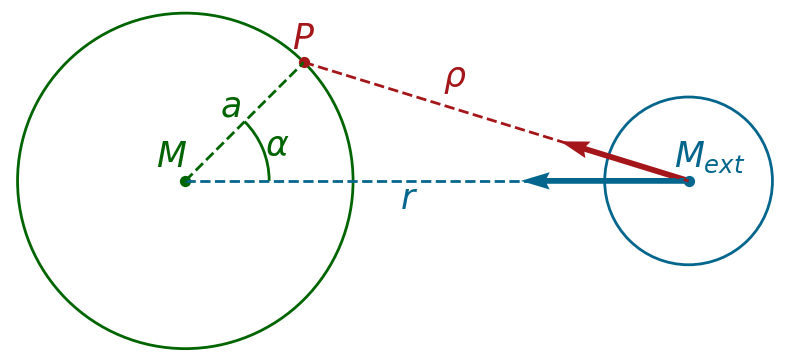

In [9]:
#Plot de la configuración
fig, ax = plt.subplots(figsize=(8,4))

#Coordinates
xe, ye = 0, 0	#Earth CM
xb, yb = 3, 0	#External body CM
angle_P = np.pi/4
xp, yp = np.cos(angle_P), np.sin(angle_P)	#Point P

#Earth sphere
earth = Circle((xe,ye), radius=1, edgecolor=colors[2], fill=False, linewidth=2)
ax.add_patch(earth)

#External body sphere
body = Circle((xb,yb), radius=0.5, edgecolor=colors[0], fill=False, linewidth=2)
ax.add_patch(body)

#Distances
ax.plot((xe,xb), (ye,yb), '--', c=colors[0], linewidth=2)	#Earth CM - External body CM
#ax.annotate(r'$R$', [xb/2,yb/2], color=colors[0], textcoords="offset points", xytext=(0, -10),
            #ha='center', fontsize=25)

ax.plot((xe,xp), (ye,yp), '--', c=colors[2], linewidth=2)	#Earth CM - Point P
ax.annotate(r'$a$', [xp/2,yp/2], color=colors[2], textcoords="offset points", xytext=(-10, 4),
            ha='center', fontsize=25)

ax.plot((xp,xb), (yp,yb), '--', c=colors[6], linewidth=2)	#Point P - External body CM

#Vectors
ax.quiver(xb, yb, xp-xb, yp-yb, color=colors[6], scale_units='xy', scale=3)
ax.annotate(r'$\rho$', [(xb+xp)/2,(yb+yp)/2], color=colors[6], textcoords="offset points",
            xytext=(-30, 25), ha='center', fontsize=25)

ax.quiver(xb, yb, xe-xb, ye-yb, color=colors[0], scale_units='xy', scale=3)
ax.annotate(r'$r$', [(xb+xe)/2,(yb+ye)/2], color=colors[0], textcoords="offset points",
            xytext=(-20, -20), ha='center', fontsize=25)

#Points
ax.scatter(xe, ye, c=colors[2], s=50)	#Earth center of mass
ax.annotate(r'$M$', [xe,ye], color=colors[2], textcoords="offset points", xytext=(-10, 10),
            ha='center', fontsize=25)

ax.scatter(xb, yb, c=colors[0], s=50, label="External body's center of mass")  #External body center of mass
ax.annotate(r'$M_{ext}$', [xb,yb], color=colors[0], textcoords="offset points", xytext=(15, 10),
            ha='center', fontsize=25)

ax.scatter(xp, yp, c=colors[6], s=50)
ax.annotate(r'$P$', [xp,yp], color=colors[6], textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=25)

#Angle
arc_radius = 1 
arc = Arc((xe, ye), arc_radius, arc_radius, angle=0, theta1=0, theta2=np.rad2deg(angle_P),
          color=colors[2], linewidth=2)
ax.add_patch(arc)
ax.annotate(r'$\alpha$', [0.55,0.15], color=colors[2], textcoords="offset points", xytext=(0, 0),
            ha='center', fontsize=25)

ax.margins(0.01)
ax.set_aspect('equal', adjustable='box')
#ax.set_title('Figure 1. Configuration of the system')
ax.set_axis_off()
fig.tight_layout()

#Save the figure
#fig.savefig(path + 'config_calculations.pdf', format='pdf', bbox_inches='tight', dpi=300);

Equation (2.1) is not the formula we will use to derive the tidal signal. However, it remains important because it helps us to initially understand the distribution of tidal forces on Earth. Assuming that the Moon is on the right side of our perfectly spherical Earth (as shown in figure (1)), and using equation (2.1), we plotted the tidal force field observed in figure (2). In this plot, as in the mathematical expression, we observe that the tidal force is zero at the Earth's COM, because $\vec{r}$ and $\vec{\rho}$ are equal there. But there are other interesting insights. In figure (2), all the arrows have been scaled firstly by Earth's average surface gravity ($g$), and then, with a sufficiently large value to make them visible, since their magnitudes are around one part per million of $g$. This allows us to use the size of the arrows to make some physical statements. For instance, the tidal forces increase with distance from the COM, as shown by the larger arrows at a greater radius. Additionally, the tidal force field for our spherically symmetric Earth appears symmetric with respect to the COM. Lastly, we drew an ellipse connecting the heads of the arrows in figure (2) to illustrate the effect of tidal forces on the planet's shape (similar to Agnew (2015)): compressing in the direction perpendicular to the line connecting the bodies, and stretching along the line. 

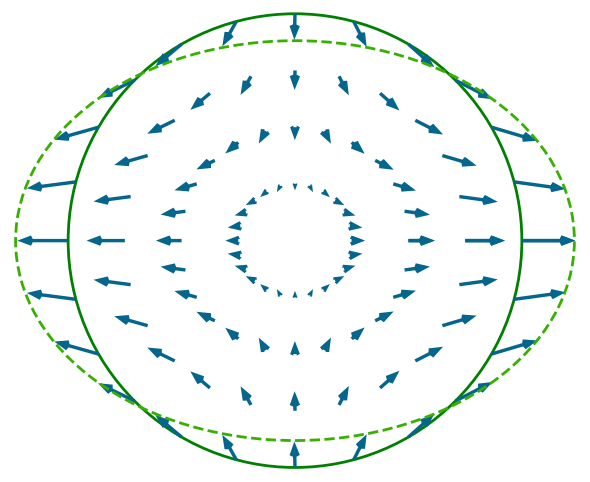

In [10]:
#Angles alphas
alphas = np.linspace(0, 2*np.pi, 25)

#Depths
a_s = np.linspace(0, a_E, 5)[1:]	#km

#Moon mean distance
r = 384e3 #km

#Moon position vector
r_vecs = np.array([-r, 0])

#Reference gravity (using GM=1)
g_ref = 1/a_E**2

#Plot tidal force field
fig, ax = plt.subplots(figsize=(6,6))

#Adding the Earth
xe, ye = 0, 0
earth = Circle((xe,ye), radius=a_E, edgecolor='green', fill=False, linewidth=2)
ax.add_patch(earth)

#Cycle over the depths
for a in a_s:

	#Cartesian coordinates of the points
	Ps = np.array([[a*np.cos(alpha), a*np.sin(alpha)] for alpha in alphas])

	#Distance external body - points
	rhos = np.sqrt(r**2 + a**2 - 2*r*a*np.cos(alphas))

	#Rho vectors components
	rho_vecs = Ps + r_vecs

	#Tidal aceleration components (assuming GM=1)
	g_tids = np.array([-rho_vecs[i]/rhos[i]**3 -(-r_vecs/r**3) for i in range(len(alphas))])
	g_tids = g_tids/g_ref	#All acelerations are scaled wrt the mean Earth surface gravity

	#Plot vectors
	scale = 1e4
	ax.quiver(Ps[:,0], Ps[:,1], g_tids[:,0], g_tids[:,1], color=colors[0],
		   		pivot='tail', scale=1/scale, width=0.006, headwidth=3, headlength=4)

	#Adding the new "equipotencial" surface
	if a==a_E:
		width = (1+np.linalg.norm(g_tids[12])*2.6e4)*a*2
		height = (1-np.linalg.norm(g_tids[6])*2.6e4)*a*2
		ellipse = Ellipse((xe, ye), width, height, angle=0, edgecolor=colors[3],
					facecolor='none', linewidth=2, linestyle='--')
		ax.add_patch(ellipse)

ax.margins(0.01)
#ax.set(xlim=[-a_E*1.3, a_E*1.3], ylim=[-a_E*1.3, a_E*1.3])
ax.set_aspect('equal', adjustable='box')
#ax.set_title('Figure 2. Tidal force field')
ax.set_axis_off()
fig.tight_layout()

#Save the plot
#fig.savefig(path + 'tidal_force_field.pdf', format='pdf', bbox_inches='tight', dpi=300);

In [11]:
#Magnitudes of biggest acceleration in the field
g_tid_max = np.max(np.linalg.norm(g_tids, axis=1))
print(f'The magnitude of biggest acceleration in the field is {g_tid_max:.1e}')

The magnitude of biggest acceleration in the field is 9.4e-06


In a real scenario, the vectors $\vec{r}$ and $\vec{\rho}$ change over time due to the Earth's orbital motion and rotation, as well as the movement of the body causing the tides. Consequently, figure (2) is only valid as a static picture, i.e., in a fixed time. Even in the case where the Earth and the Moon are in a circular orbit, and the magnitude of $\vec{r}$ remains constant, there is still a variation in the tidal force at point $P$ caused by Earth's rotation. The planet's rotation moves the vector $\vec{\rho}$ around the rotation axis, and changes its relative position to the COM. In this case, the tidal signal will exhibit only diurnal and semi-diurnal variations. Only in a circular orbit with strict tidal locking of the Earth, when rotation and orbital motion are coupled, would the tidal field not change over time. In this scenario, the force field will always be as shown in figure (2).


## **Tidal potential**

As we suggested previously, *tidal forces* arise from the gravitational attraction of external bodies on the Earth. Calculating these forces requires only a basic understanding of potential theory and celestial mechanics. However, these calculations traditionally report accelerations (or specific forces) rather than forces. In this sense, the tidal force at a point $P$ on or inside the Earth is defined as the difference between the acceleration caused by an external body on that point ($\vec{g}_{P}$), and the orbital acceleration ($\vec{g}_{\text{orb}}$), the acceleration experienced by the Earth as a whole in its orbit (Agnew, 2015). Mathematically, we can write this definition as:

\begin{align}
V_{tot}=\frac{GM_{ext}}{\rho} = \frac{GM_{ext}}{r} \frac{1}{(1+(a/r)^{2}-2(a/r)\cos{\alpha})^{1/2}}
\tag{2.2}
\end{align}

In this last expression, we have used the law of cosines to express $\rho$ in terms of $a$, $r$ and $\alpha$. We also factored out the common distance $r$. The term inverse to the square root is similar to the generating function for Legendre Polynomials (see appendix A):

\begin{equation*}
\sum_{n=0}^{\infty} t^{n}P_{n}(x) = \frac{1}{(1+t^{2}-2xt)^{1/2}}
\end{equation*}

Then, if we take $t=(a/r)$ and $x=\cos{\alpha}$, the potential can be written as:

\begin{align}
V_{tot} = \frac{GM_{ext}}{r} \sum_{n=0}^{\infty} \left(\frac{a}{r}\right)^{n}P_{n}(\cos{\alpha})
\tag{2.3}
\end{align}

Equation (2.3) is an important expression, but it represents the total gravitational potential due to $M_{ext}$, not the TGP. It is important to remember that tides result from gravitational attraction, but are not gravitational attraction itself. They are related to the difference in the gravitational force, or in the gravitational potential, with respect to the COM. In practice, this means that certain terms must be subtracted from the potential in equation (2.3). Which terms? Those associated with the gravitational attraction felt by the Earth as a whole due to its orbit with $M_{ext}$: the potential responsible for the orbital centrifugal acceleration. By expanding $V_{tot}$ up to $n=2$ and using the values for $P_{n}$ (see definitions in appendix A), these terms can easily be identified:

In [12]:
#Degree, order, angle
n, m, alpha= sp.symbols('n m alpha')

#Polinomios de Legendre
Pn = sp.legendre(n, sp.cos(alpha))

nmax = 6
for i in range(0,nmax+1):
    print(f'Para n={i}, P={sp.legendre(i, sp.cos(alpha))}')

Para n=0, P=1
Para n=1, P=cos(alpha)
Para n=2, P=3*cos(alpha)**2/2 - 1/2
Para n=3, P=5*cos(alpha)**3/2 - 3*cos(alpha)/2
Para n=4, P=35*cos(alpha)**4/8 - 15*cos(alpha)**2/4 + 3/8
Para n=5, P=63*cos(alpha)**5/8 - 35*cos(alpha)**3/4 + 15*cos(alpha)/8
Para n=6, P=231*cos(alpha)**6/16 - 315*cos(alpha)**4/16 + 105*cos(alpha)**2/16 - 5/16


\begin{align}
\begin{split}
	V_{total} &= \frac{GM_{\text{ext}}}{R}\left(\frac{a}{r}\right)^{0}P_{0} + \frac{GM_{\text{ext}}}{r}\left(\frac{a}{r}\right)P_{1} + \frac{GM_{\text{ext}}}{r} \sum_{n=2}^{\infty} \left(\frac{a}{r}\right)^{n}P_{n}(\cos{\alpha})\\
	&= \frac{GM_{\text{ext}}}{r} + \frac{GM_{\text{ext}}}{r^{2}} a\cos{\alpha} + \frac{GM_{\text{ext}}}{r} \sum_{n=2}^{\infty} \left(\frac{a}{r}\right)^{n}P_{n}(\cos{\alpha})
\end{split}
\tag{2.4}
\end{align}

The first term in this expression is physically irrelevant because it is a constant term and its gradient (spatial derivative) will vanish, hence we can neglect it. On the other hand, the second term is the one that gives us the orbital centrifugal acceleration. We can prove this by setting $a\cos{\alpha} = x$ and defining $x$ as the Cartesian coordinate along the vector joining the COMs, and by calculating the gradient:

\begin{align}
	\nabla V_{1} = \frac{\partial}{\partial x} \left(\frac{GM_{\text{ext}}}{r^{2}}x\right)\hat{x} = \frac{GM_{\text{ext}}}{r^{2}}\hat{x} = -\vec{g}_{orb}
\tag{2.5}
\end{align}

In the last step, we used that $\hat{x} = \hat{r}$ by our definition of this Cartesian coordinate. Finally, removing this term, the expression for the TGP is:

\begin{align}
V_{tid}(t) = \frac{GM_{\text{ext}}}{r(t)}\sum_{n=2}^{\infty}\left(\frac{a}{r(t)}\right)^{n}P_{n}(\cos{\alpha(t)})
\tag{2.6}
\end{align}

Where we made explicit the time dependence of $V_{tid}$ through $r$ and $\alpha$.

#### **Comparison between different external bodies:**

But not all the terms in equation (2.6) have to be considered. Due to the physical and geometrical interpretation of the argument inside the Legendre Polynomials, we can state that $|P(\cos{\alpha})| \leq 1$. Hence, in a very optimistic case, we can evaluate how quickly $(a/r)^{n}$ converges by choosing $a=a_{\oplus}$ and $r$ as the minimum possible distance between the Earth, the Moon, the Sun, and the planets. This allows us to discard some terms in the sum that contribute very little. As we can see in figure (3), the term $(a_{\oplus}/r)^{n}$ converges very quickly for most bodies. For this reason, in practice, only terms up to degree $n=2$ are usually considered for the Sun and the planets, and up to $n=4$ for the Moon (Agnew, 2015).

In [13]:
#External bodies and their minimun distance to the Earth
ext_bodies = ['Moon', 'Sun', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
id_ext_bodies = ['@301', '@399', '@199', '@299', '@499', '@599', '@699', '@799', '@899']
#399 is the Earth ID not the Sun, but I'm calculating Earth elements wrt the Sun in that case

#Date to test
date_test = dict(start='2025-01-01 00:00:00', stop='2025-01-01 23:59:59', step='1h')

#List with the distances
qs = []		#Periapsis
Qs = []		#Apoapsis
for i, body in enumerate(ext_bodies):
	if body == 'Moon':
		extbody = Horizons(id=id_ext_bodies[i], location="@399", epochs=date_test)
		element = extbody.elements()
		qs.append(element[0]['q'])
		Qs.append(element[0]['Q'])
	else:
		extbody = Horizons(id=id_ext_bodies[i], location="@10", epochs=date_test)
		element = extbody.elements()
		qs.append(element[0]['q'])
		Qs.append(element[0]['Q'])

In [14]:
#For the Earth
q_E, Q_E = qs[1], Qs[1]

#List with the most optimistic distances
rs_min = []		#in [au]
for i,body in enumerate(ext_bodies):
    if body == 'Moon' or body == 'Sun':
        rs_min.append(qs[i])	#Min distance in this case is the periapsis
    elif body == 'Mercury' or body == 'Venus':	#Inner planets
        rs_min.append(q_E-Qs[i])
    else:	#Outer planets
        rs_min.append(qs[i]-Q_E)
rs_min = np.array(rs_min)*au/1e3	#in [km]

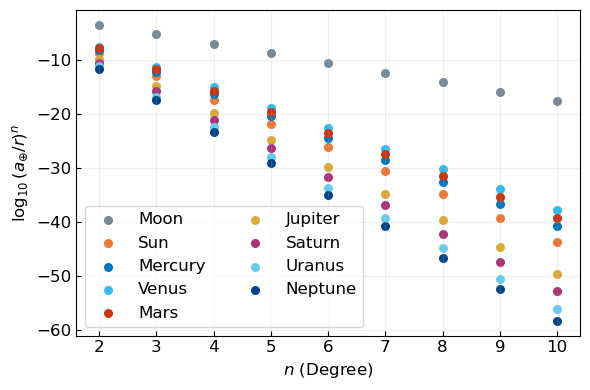

In [15]:
#Plot de (a_E/R)^n
fig, ax = plt.subplots(figsize=(6,4))

#Radius distance rate
ars = a_E/rs_min

n = np.arange(2, 11)
for i,body in enumerate(ext_bodies):
    ax.scatter(n, np.log10(ars[i]**n), s=30, c=body_colors[body], label=f'{body}')

#ax.set_yscale('log')
#ax.set_title('Figure 3. Convergence of $(a/R)^{n}$ for different external bodies', fontsize=10)
ax.set_xlabel(r'$n$ (Degree)', fontsize=12)
ax.set_ylabel(r'$\log_{10}(a_{\oplus}/r)^{n}$', fontsize=12)
ax.legend(ncol=2, fontsize=12)
#ax.margins()
ax.grid(alpha=0.2)


ax.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
fig.tight_layout()

#Save the figure
#fig.savefig(path + 'ar_convergence.pdf', format='pdf', bbox_inches='tight', dpi=300);

We can also compare the contribution of every planetary body to the tidal signal for the first degree of the TGP expansion, $n=2$. Assuming that $a^2P_2(\cos\alpha)$ is the same for all bodies, we find that:

\begin{align}
	V_{tid} \propto \frac{GM_{\text{ext}}}{r^{3}}
\tag{2.7}
\end{align}

Table (2.1) shows the value of this term for different planetary bodies, once again taking $r$ as the minimum possible distance between Earth and each body. In this optimistic scenario, which is not far from reality, the Moon is the main contributor to the tidal signal, followed by the Sun, which is farther away but has a much larger gravitational parameter, $GM_{\text{ext}}$. Since the Moon's contribution is larger, we also compare the other contributions relative to this one. The calculation is consistent with what others have reported (Tokieda, 2013; Agnew, 2015): the Sun's contribution is almost half that of the Moon. After the Sun, Venus and Jupiter make the next biggest contributions, but these are in the order of parts per million compared to the Moon. This is essentially why, when studying the tides on Earth, it is common to refer to them as \textit{lunisolar tides}, omitting the contribution of the planets.

In [16]:
#GM/r^3 de cada objeto
factor = []
for i,body in enumerate(ext_bodies):
    GM_ext = spy.bodvrd(body, "GM", 1)[1][0]	#in [km^3/s^2]
    factor.append(GM_ext/rs_min[i]**3)
    print(f'For {body}:\n GM = {(GM_ext)} km^3/s^2 \n GM/R^3 = {factor[i]} s^-2 \n')

For Moon:
 GM = 4902.800118457549 km^3/s^2 
 GM/R^3 = 9.592589587602166e-14 s^-2 

For Sun:
 GM = 132712440041.27939 km^3/s^2 
 GM/R^3 = 4.168995328170904e-14 s^-2 

For Mercury:
 GM = 22031.868551400003 km^3/s^2 
 GM/R^3 = 4.772295559163858e-20 s^-2 

For Venus:
 GM = 324858.592 km^3/s^2 
 GM/R^3 = 5.8432114258251705e-18 s^-2 

For Mars:
 GM = 42828.37362069909 km^3/s^2 
 GM/R^3 = 2.6770399431023894e-19 s^-2 

For Jupiter:
 GM = 126686531.9003704 km^3/s^2 
 GM/R^3 = 6.219849162833579e-19 s^-2 

For Saturn:
 GM = 37931206.23436167 km^3/s^2 
 GM/R^3 = 2.204982272169969e-20 s^-2 

For Uranus:
 GM = 5793951.256527211 km^3/s^2 
 GM/R^3 = 3.283841776871825e-22 s^-2 

For Neptune:
 GM = 6835103.145462294 km^3/s^2 
 GM/R^3 = 8.56172880510856e-23 s^-2 



Normalizing with the value $\frac{GM}{r^{3}}$ for the Moon:

In [17]:
#Normalización de GM/R^3 con respecto al valor de la Luna
factor_norm = np.array(factor)/factor[0]
for i,body in enumerate(ext_bodies):
    print(f'For {body}, GM/r^3 = {factor_norm[i]:.2e} of the Moon value')

For Moon, GM/r^3 = 1.00e+00 of the Moon value
For Sun, GM/r^3 = 4.35e-01 of the Moon value
For Mercury, GM/r^3 = 4.97e-07 of the Moon value
For Venus, GM/r^3 = 6.09e-05 of the Moon value
For Mars, GM/r^3 = 2.79e-06 of the Moon value
For Jupiter, GM/r^3 = 6.48e-06 of the Moon value
For Saturn, GM/r^3 = 2.30e-07 of the Moon value
For Uranus, GM/r^3 = 3.42e-09 of the Moon value
For Neptune, GM/r^3 = 8.93e-10 of the Moon value


In [18]:
#Comparative table (Table 2.1)
data_comp_tides = {
    "Body": ext_bodies,
    "GM/r^3 (s^-2)": factor,
    "GM/r^3 (Moon)": factor_norm
}

data_comp_tides = pd.DataFrame(data_comp_tides)
data_comp_tides.to_latex(index=False, float_format='%.2e')

'\\begin{tabular}{lrr}\n\\toprule\nBody & GM/r^3 (s^-2) & GM/r^3 (Moon) \\\\\n\\midrule\nMoon & 9.59e-14 & 1.00e+00 \\\\\nSun & 4.17e-14 & 4.35e-01 \\\\\nMercury & 4.77e-20 & 4.97e-07 \\\\\nVenus & 5.84e-18 & 6.09e-05 \\\\\nMars & 2.68e-19 & 2.79e-06 \\\\\nJupiter & 6.22e-19 & 6.48e-06 \\\\\nSaturn & 2.20e-20 & 2.30e-07 \\\\\nUranus & 3.28e-22 & 3.42e-09 \\\\\nNeptune & 8.56e-23 & 8.93e-10 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### **Potential in Geographic Coordinates**

Equation (2.6) for the TGP is in terms of the geocentric angle $\alpha$, which represents the angular distance between the point $P$ on Earth where the tide is being calculated, and the subpoint (the projection) of the external body $M_{\text{ext}}$ onto the Earth's surface. While we previously studied the convergence of this expression for different bodies, we did not actually calculate the value of the TGP for a specific location on Earth at a particular time. To achieve this, it is preferable to express the angle $\alpha$ in terms of *geographic coordinates* using the *law of cosines for spherical triangles*:

\begin{align*}
%\label{eq:law_of_cosines_sph_triangles}
	\cos{\alpha} = \cos{\theta}\cos{\theta'} + \sin{\theta}\sin{\theta'}\cos{(\phi' - \phi)}
\tag{2.8}
\end{align*}


Where $\theta$ and $\phi$ are the colatitude and longitude of point $P$ on Earth, respectively, and $\theta'$ and $\phi'$ are the colatitude and longitude of the projection of the external body onto the Earth. Inserting the expression for $\cos{\alpha}$ in the Legendre Polynomials, along with some developments in mathematical physics, we arrive at the addition theorem for spherical harmonics (see appendix A.2). Substituting the addition theorem into the potential yields to:

\begin{equation}
V_{\text{tid}} = \frac{GM_{\text{ext}}}{r} \sum_{n=2}^{\infty} \left( \frac{a}{r} \right)^{n} \frac{4\pi}{2n+1} \sum_{m=-n}^{n} \overline{Y}_{n}^{m}(\theta'(t),\phi'(t)) Y_{n}^{m}(\theta,\phi)
\tag{2.9}
\end{equation}

By convention, the TGP is often expressed as $V_{\text{\text{tid}}}/g$, where $g$ is a gravitational acceleration of reference. In our case, we will assume that $g$ is the acceleration for the Earth's mean radius ($a_{\oplus}$):

\begin{align}
%\label{eq:equatorial_gravity}
	g = \frac{GM_{\oplus}}{a_{\oplus}^{2}}
\tag{2.10}
\end{align}

When dividing equation (2.8) by $g$, we get the following expression:

\begin{align}
%\label{eq:tidal_potential_wrt_geoid}
\begin{split}
\frac{V_{\text{\text{tid}}}}{g} &= \frac{GM_{\text{ext}}}{r} \frac{a_{\oplus}^{2}}{GM_{\oplus}} \sum_{n=2}^{\infty} \left( \frac{a}{r} \right)^{n} \frac{4\pi}{2n+1} \sum_{m=-n}^{n} \overline{Y}_{n}^{m}(\theta'(t),\phi'(t)) Y_{n}^{m}(\theta,\phi) \\
&= a_{\oplus}^{2} \frac{M_{\text{ext}}}{M_{\oplus}} \sum_{n=2}^{\infty} \frac{a^{n}}{r^{n+1}} \frac{4\pi}{2n+1} \sum_{m=-n}^{n} \overline{Y}_{n}^{m}(\theta'(t),\phi'(t)) Y_{n}^{m}(\theta,\phi)
\end{split}
\tag{2.11}
\end{align}

In addition, we can group the constant terms with the distance $a$ from the COM (similar to Agnew, 2015)$^{1}$:

\begin{equation}
%\label{eq:Kn_definition}
	K_{n}(a) = a_{\oplus}^{2} a^{n} \frac{M_{\text{ext}}}{M_{\oplus}} \frac{4\pi}{2n+1}
\tag{2.12}
\end{equation}

And using this definition of $K_n$ in the TGP, we obtain the following expression:

\begin{equation}
\boxed{\frac{V_{\text{tid}}(t)}{g} = \sum_{n=2}^{\infty} \frac{K_{n}(a)}{r(t)^{n+1}} \sum_{m=-n}^{n} \overline{Y}_{n}^{m}(\theta'(t),\phi'(t)) Y_{n}^{m}(\theta, \phi)}
\tag{2.13}
\end{equation}

Equation (2.13) is very helpful for calculating the tides at any depth on Earth using astronomical tools that determine the position of celestial bodies over time. However, it may be useful to try to understand what the highlighted quantity is. One way to do this is through dimensional analysis:

\begin{align*}
\left[ \frac{V_{\text{\text{tid}}}}{g} \right] = \frac{\text{J/kg}}{\text{m/s}^2} = \frac{\text{m}^2/\text{s}^2}{\text{m/s}^2} = \text{m}
\end{align*}

Thus, $V_{\text{tid}}/g$ has units of length or displacement. Since the implied quantity is the potential, this can be interpreted as a height with respect to the equipotential surface of the Earth's gravity field that most closely coincides with mean sea level, the *geoid*. This can't be confused with the amount of movement that the ocean will undergo because of the TGP. Neither is the TGP the total additional gravitational potential. As we will see in the following chapters, the additional potential and the real displacements on Earth are going to be a fraction of these quantities and will also depend on the planetary response.

Moreover, we can already observe another property of the TGP in equation (2.7). The value of each component of degree $n$ in the TGP varies as $(a/a_{\oplus})^{(n)}$ as we move towards or away from the COM, which can be proven by manipulating the terms in equation (2.12) slightly:

\begin{equation}
	K_{n}(a) = a_{\oplus}^{n+2} \frac{M_{\text{ext}}}{M_{\oplus}} \frac{4\pi}{2n+1} \left(\frac{a}{a_{\oplus}}\right)^{n} = K_{n}(a_{\oplus}) \left(\frac{a}{a_{\oplus}}\right)^{n}
\tag{2.14}
\end{equation}

Therefore, using \cref{eq:Kn_a_variation} we can also write the potential as follows:

\begin{equation}
	\frac{V_{\text{\text{tid}}}(t)}{g} = \sum_{n=2}^{\infty} \left(\frac{a}{a_{\oplus}}\right)^{n} \frac{K_{n}(a_{\oplus})}{r(t)^{n+1}} \sum_{m=-n}^{n} \overline{Y}_{n}^{m}(\theta'(t),\phi'(t)) Y_{n}^{m}(\theta, \phi)
\tag{2.15}
\end{equation}

For now, we can use either equation (2.7) or equation (2.15) to calculate the tidal potential on the Earth, or any other planetary body, by replacing $M_{\odot}$ and $a_{\odot}$ by its mass and mean radius, respectively. This will be our initial approximation of the tidal signal.

$^{1}$ They work with $\overline{r}$ because the mean distances to other bodies are well known for the Earth. However, our choice of $K_{n}$ allows us to have a more general (or programmable) form of the TGP that can easily be extended to other planetary bodies.


**Note:** Sometimes it is useful to express the time variation of the distance $r(t)$ as:

\begin{align}
%\label{eq:distance_variation}
	r(t) = \frac{\overline{r}}{\xi(t)}
\tag{2.10}
\end{align}

In this expression, $\overline{r}$ is the mean distance to the body and $\xi(t)$ is the variation factor. If $\xi(t) > 1$, then $r(t) < \overline{r}$ (the body is closer than average), and if $\xi(t) < 1$, then $r(t) > \overline{r}$ (the body is farther away).

## **Direct calculation**

To test the expression derived for the potential, we can calculate the related signal for the Moon within a specific time interval at a particular location on Earth. For this purpose, we can utilise a Python package called TSPICE, developed in this study, which can quickly and easily compute this signal using astronomical ephemerides. This type of calculation, employing equations 2.7 with the ephemerides, is known as a direct calculation of the TGP. Chapter 5 offers a detailed overview of the methodology used to develop TSPICE and compute the tides. For now, we will demonstrate and describe the signal.

In [19]:
#Create the object Body
earth = tsp.Body('Earth')

#Coordinates of the station in radians
loc = dict(lat = 4.49,
           lon = -73.14,
           depth = 0)	#Real depth 9km

#Dictionary with the start, stop, and step data ## Real time 13:08:05
date = dict(start = '2025-05-25 00:00:00',
            stop = '2025-06-22 00:00:00',
            step = '1h',
            time_frame = 'UTC')

#Get the tidal potential due just to the Moon
tgp_earth_moon, et_utc = earth.tgp_one_body('Moon', loc_sta=loc, dates=date, nmax=6, time_array=True)

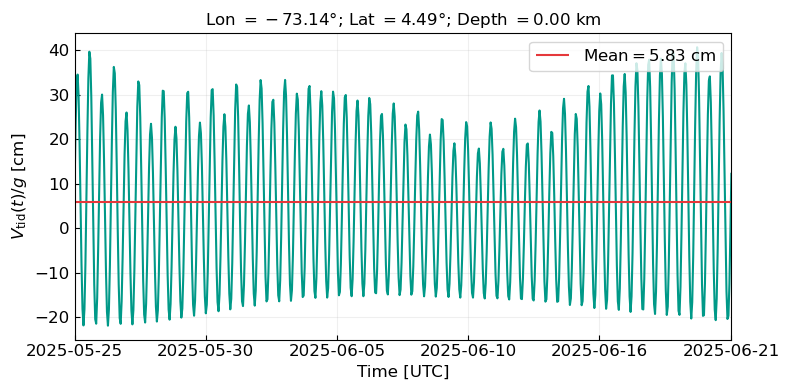

In [21]:
#Plotting the signal
tsp.plot_one_signal(et_utc, tgp_earth_moon*100, loc, colors=[body_colors['Earth'], colors[7]], mean_value=True)#, savepath=path+'TGPsignal_first_example.pdf')

In [22]:
#List of bodies to consider for tidal calculations
bodylist = ['Moon', 'Sun', 'Mercury', 'Venus', 'Mars', 'Jupiter']

In [ ]:
#Signal with contributions of the Sun, Moon and planets
tgp_earth_bodies, et_utc = earth.tgp_many_bodies(bodylist, loc_sta=loc, dates=date, nmax=6, time_array=True, body_signal=True)
tgp_earth_total = tgp_earth_bodies.sum(axis=1)	#Sum the contribution of each body
tgp_earth_mean = tgp_earth_total.mean()

#Convert ET to UTC
utc_times = tsp.utils.et_to_utc_string(et_utc)

Moon contribution calculated!
Sun contribution calculated!
Mercury contribution calculated!
Venus contribution calculated!
Mars contribution calculated!
Jupiter contribution calculated!


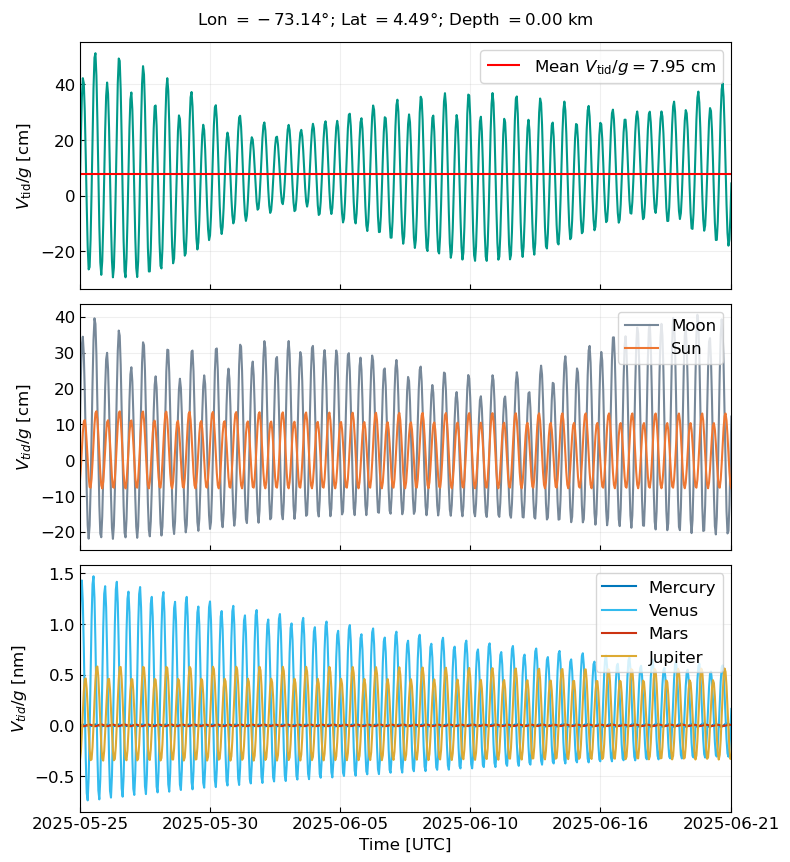

In [24]:
#Plot of Vtid/g in time
fig, ax = plt.subplots(3,1,figsize=(8,8.75), sharex=True)

#Taking 5 equally spaced times
ticks = np.linspace(0, len(utc_times)-1, 6, dtype=int)

#Total signal
ax0 = ax[0]
ax0.plot(utc_times, tgp_earth_total*100, color=body_colors['Earth'])
ax0.hlines(tgp_earth_mean*100, utc_times[0], utc_times[-1], color='red', label=r'Mean $V_{\text{tid}}/g=%.2f$ cm'%(tgp_earth_mean*100))
#ax0.set_xlabel('Time [UTC]', fontsize=12)
ax0.set_ylabel(r'$V_{\text{tid}}/g$ [cm]', fontsize=12)
#ax0.set_title('Total tide-generating potential signal', fontsize=12)
ax0.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax0.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax0.legend(fontsize=12, loc='upper right')
ax0.margins(x=0)
ax0.grid(alpha=0.2)

ax0.set_xticks([utc_times[i] for i in ticks])


#Moon and Sun contributions
ax1 = ax[1]
ax1.plot(utc_times, tgp_earth_bodies[:,0]*100, label='Moon', color=body_colors['Moon'])
ax1.plot(utc_times, tgp_earth_bodies[:,1]*100, label='Sun', color=body_colors['Sun'])
ax1.set_ylabel(r'$V_{tid}/g$ [cm]', fontsize=12)
#ax1.set_xlabel('Time [UTC]', fontsize=12)
#ax1.set_title('Moon and Sun contributions', fontsize=12)
ax1.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax1.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.legend(fontsize=12, loc='upper right')
ax1.margins(x=0)
ax1.grid(alpha=0.2)

ax1.set_xticks([utc_times[i] for i in ticks])


#Planetary contributions
ax2 = ax[2]
ax2.plot(utc_times, tgp_earth_bodies[:,2]*1e6, label='Mercury', color=body_colors['Mercury'])
ax2.plot(utc_times, tgp_earth_bodies[:,3]*1e6, label='Venus', color=body_colors['Venus'])
ax2.plot(utc_times, tgp_earth_bodies[:,4]*1e6, label='Mars', color=body_colors['Mars'])
ax2.plot(utc_times, tgp_earth_bodies[:,5]*1e6, label='Jupiter', color=body_colors['Jupiter'])
ax2.set_xlabel('Time [UTC]', fontsize=12)
ax2.set_ylabel(r'$V_{tid}/g$ [nm]', fontsize=12)
#ax2.set_title('Planetary contributions', fontsize=12)
ax2.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax2.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.legend(fontsize=12, loc='upper right')
ax2.margins(x=0)
ax2.grid(alpha=0.2)

ax2.set_xticks([utc_times[i] for i in ticks])

fig.suptitle('Lon $= %.2f$°; Lat $= %.2f$°; Depth $= %.2f$ km' % (loc['lon'], loc['lat'], loc['depth']), fontsize=12)
fig.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout()
#fig.savefig(path + 'TGPsignal_second_example.pdf', format='pdf', bbox_inches='tight', dpi=300)

## **Harmonic decomposition**

In [26]:
#Create the main body object for Earth
earth = tsp.Body('EARTH')

#Coordinates of the station in radians
loc = dict(lat = 4.49,
           lon = -73.14,
           depth = 9)

#Magnitude
#Mw = 6.3

#Dictionary with the start, stop, and step data
date = dict(start = '2025-01-01 00:00:00',
            stop = '2026-01-01 00:00:00',
            step = '30m',
            time_frame = 'UTC')

#List of bodies to consider for tidal calculations
bodylist = ['Moon', 'Sun', 'Mercury', 'Venus', 'Mars', 'Jupiter']

#Get the total tidal signal due to all the bodies in the list
Vgtid_array, et_utc = earth.tgp_many_bodies(bodylist, loc_sta=loc, dates=date, nmax=6, time_array=True)
Vmean_total = Vgtid_array.mean()

Moon contribution calculated!
Sun contribution calculated!
Mercury contribution calculated!
Venus contribution calculated!
Mars contribution calculated!
Jupiter contribution calculated!


In [27]:
#Times in seconds
t = (et_utc-et_utc.min())/(3600*24)	#Days
frequency, power = LombScargle(t*u.day, Vgtid_array*u.m).autopower(maximum_frequency=3*u.day**-1)
amplitude = (power.value)**0.5

#Create a dataframe with the results
spectrum_df = pd.DataFrame({'frequency (1/d)': frequency.value,
                            'period (d)': 1/frequency.value,
                            'power': power.value,
							'amplitude': amplitude})
spectrum_df = spectrum_df.sort_values(by='amplitude', ascending=False)
spectrum_df

,frequency (1/d),period (d),power,amplitude
3526,1.932439,0.517481,7.400868e-01,0.860283
3525,1.931891,0.517628,7.015245e-01,0.837571
3527,1.932987,0.517334,5.973896e-01,0.772910
3524,1.931343,0.517774,5.042978e-01,0.710139
3528,1.933535,0.517187,3.544224e-01,0.595334
...,...,...,...,...
5400,2.959347,0.337912,2.361432e-08,0.000154
5390,2.953867,0.338539,2.279906e-08,0.000151
5395,2.956607,0.338226,2.275341e-08,0.000151
1971,1.080336,0.925638,1.741238e-08,0.000132


In [28]:
#To find peaks in the signal
from scipy.signal import find_peaks

In [29]:
#Peaks in the spectrum
treshhold_amp = 0.06	#Threshold for the peaks in power
peaks_ind = find_peaks(amplitude, height=treshhold_amp, distance=30)[0]
peaks_freq = spectrum_df.loc[peaks_ind,'frequency (1/d)'].values
peaks_power = spectrum_df.loc[peaks_ind,'power'].values
peaks_amplitude = spectrum_df.loc[peaks_ind,'amplitude'].values

print(f'Number of peaks {len(peaks_ind)} in the spectrum for a threshold of {treshhold_amp} in amplitude')

#Create a dataframe with the peaks
peaks_df = pd.DataFrame({'frequency (1/d)': peaks_freq,
								  'period (d)': 1/peaks_freq,
								  'power': peaks_power,
								  'amplitude': peaks_amplitude})
peaks_df['period'] = 1/peaks_df['frequency (1/d)']
peaks_df = peaks_df.sort_values(by='period', ascending=False, ignore_index=True)
peaks_df

Number of peaks 6 in the spectrum for a threshold of 0.06 in amplitude


,frequency (1/d),period (d),power,amplitude,period
0,0.073155,13.669632,0.012439,0.111529,13.669632
1,0.929642,1.075683,0.004589,0.067740,1.075683
2,1.003071,0.996938,0.008264,0.090908,0.996938
3,1.895725,0.527503,0.032403,0.180007,0.527503
4,1.932439,0.517481,0.740087,0.860283,0.517481
5,2.000388,0.499903,0.172088,0.414835,0.499903


In [ ]:
#Names of the peaks in the Darwin Symbols
names_darwin = [r'$M_{f}$', r'$O_{1}$', r'$K_{1}$', r'$N_{2}$', r'$M_{2}$', r'$S_{2}$']

['$M_{f}$', '$O_{1}$', '$K_{1}$', '$N_{2}$', '$M_{2}$', '$S_{2}$']


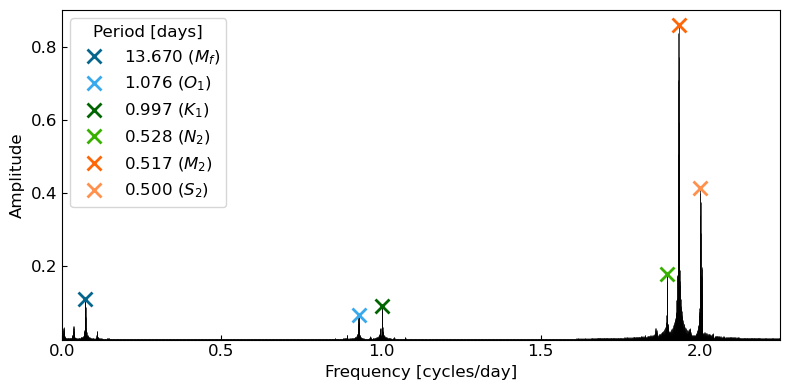

In [31]:
#Plot del espectro de la señal de mareas
fig, axs = plt.subplots(figsize=(8,4))
fs, amps = frequency.value, amplitude

#Total spectrum
axs.vlines(fs, np.zeros(len(fs)), amps, color='black', lw=0.5)
#axs.plot(fs, amps, color='black')
for i, (f, a, p) in enumerate(zip(peaks_df['frequency (1/d)'], peaks_df['amplitude'], peaks_df['period'])):
  axs.plot(f, a,'x', color=colors[i], ms=10, mew=2, label=r'$%.3f$ (%s)' %(p, names_darwin[i]))
axs.set_xlabel('Frequency [cycles/day]', fontsize=12)
axs.set_ylabel('Amplitude', fontsize=12)
axs.set(xlim=(0,2.25), ylim=(0,0.9))

axs.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
axs.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
axs.set_xticks(np.linspace(0, 2.0, 5))
axs.set_yticks(np.linspace(0.2, 0.8, 4))

axs.legend(loc='best', ncols=1, fontsize=12, title='Period [days]', title_fontsize=12)

fig.tight_layout();
fig.savefig(path + 'Harmonic_decomposition_example.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Draft

### **Programa general**

Un programa general que me dé el potencial de marea para cualquier lugar de la Tierra, considerando el Sol, la Luna y los planetas, deber incluir los siguientes parámetros para cada cuerpo:

- $M/M_{E}$: Masa relativa entre la Tierra y el cuerpo externo. Los obtengo de la página de la [IAU](https://iau-a3.gitlab.io/NSFA/NSFA_cbe.html#MMME2009).
- $\overline{R}$: Distancia media de la Tierra al cuerpo externo.
- $\xi(t)=\overline{R}/R(t)$: Variación temporal de la distancia.
- $(\theta'(t),\phi'(t))$: Coordenadas del subpunto del cuerpo externo sobre la Tierra.

Para almacenar los $M/M_{E}$ y $\overline{R}$ de cada cuerpo externo (Luna, Sol y planetas) crearemos una lista de directorios. En el directorio de cada planeta incluiremos el `id` con el que podemos buscar la información orbital del cuerpo usando Horizons.

In [ ]:
#Masas
Ms = aconst.M_sun.value		#Masa del Sol [kg]
Me = aconst.M_earth.value	#Masa de la Tierra [kg]
Ms_Me = Ms/Me	 #Masa del Sol respecto a la Tierra [adim]

#Parámetros planetarios
extbodies = {'Moon':{id:301, M_Me:1.23000371e-2},
           'Sun':{id:10, M_Me:Ms_Me},
			  'Mercury':{id:199, M_Me:Ms_Me*1/6.023657330e6},
				'Venus':{id:299, M_Me:Ms_Me*1/4.08523719e5},
				'Mars':{id:499, M_Me:Ms_Me*1/3.09870359e6},
				'Jupiter':{id:599, M_Me:Ms_Me*1/1.047348644e3},
				'Saturn':{id:699, M_Me:Ms_Me*1/3.4979018e3},
				'Uranus':{id:799, M_Me:Ms_Me*1/2.2902951e4},
				'Neptune':{id:899, M_Me:Ms_Me*1/1.941226e4}
				}

Nuestro programa general para calcular mareas debe recibir:

- Las coordenadas $(\phi,\theta)$ sobre la Tierra del lugar en el que se quiere calcular el potencial.
- La lista de los cuerpos externos que se quieren considerar en el cálculo de las mareas.
- Las fechas inicial y final sobre las que se quiere calcular el potencial junto con el paso de tiempo. Esto se debe pasar como un diccionario.
- El máximo grado a tener en cuenta en la suma de los potenciales (el cálculo siempre empieza desde $n=2$).
 

In [ ]:
#Coordenadas de una estación en Tierra
lat_s, lon_s = 10.374540661878331, -75.47267939885302
colat_s = 90 - lat_s    #Colatitud
theta_s, phi_s = np.deg2rad(colat_s), np.deg2rad(lon_s)

#Lista de cuerpos con los que quiero calcular las mareas
bodylist = ['Moon', 'Sun', 'Mercury', 'Venus', 'Mars', 'Jupiter']

#Diccionario de fechas (start, stop, step)
date = dict(start="2025-01-01 00:00:00",
				stop="2025-01-29 00:00:00",
				step="1h")

#Máximo grado considerado en el cálculo
n=6

El programa general `Vtidal` para calcular el potencial de mareas sobre un lugar en la Tierra es:

In [ ]:
#Función del potencial de marea
def Vtidal(phi_s, theta_s, bodies=bodylist, dates=date, nmax=6):

	'''Este programa calcula el potencial de marea en una estación terrestre con
	coordenadas geográficas (phi_s, theta_s), debido a una lista de cuerpos externos.
	
	Recibe:
	- phi_s: Longitud de la estación [rad].
	- theta_s: Colatitud de la estación [rad].
	- bodies: Lista de cuerpos externos a considerar. Por ejemplo: ['Moon', 'Sun', 'Mercury']
	- dates: Diccionario con las fechas de inicio, fin y paso. Por ejemplo:
	dict(start="2025-01-01 00:00:00", stop="2025-01-29 00:00:00", step="1h")
	- nmax: Grado máximo a considerar en el cálculo de la marea.

	Devuelve:
	- Vtid: Arreglo con las series de tiempo de V/g en la estación para cada cuerpo
	- tjd: Tiempos en JD de las efemérides (y de los V/g).
	'''

	#Arreglo para guardar todas las series de tiempo de V/g de todos los cuerpos
	Vtid = []

	#Ciclo sobre los cuerpos externos
	for i,body in enumerate(bodies):
		
		#Efemérides del cuerpo externo	
		extbody = Horizons(id=extbodies[body][id],location="@399",epochs=dates)
		ephem = extbody.ephemerides().to_pandas() #Datos efemérides

		#Distancia al cuerpo externo en el tiempo
		Rt = ephem['delta'].to_numpy()*au

		if i==0:
			
			#Tiempo de las efemérides en JD
			tjd = ephem['datetime_jd'].to_numpy()
			te = Time(tjd, format='jd', scale='tdb')

		#Constante de normalización
		R_mean = Rt.mean()
		xit = R_mean/Rt

		#Coordenadas de la Luna (RA, DEC del ICRF)
		dec_e = ephem['DEC_app'].to_numpy() #Declinación de la Luna
		ra_e = ephem['RA_app'].to_numpy()   #Ascensión recta de la Luna

		#Transformación a coordenadas ITRF
		c_icrf = SkyCoord(ra=ra_e*u.deg, dec=dec_e*u.deg, frame='icrs', obstime=te)
		x_e = (c_icrf.itrs.x).value #Estos vectores están normalizados
		y_e = (c_icrf.itrs.y).value
		z_e = (c_icrf.itrs.z).value

		#Coordenadas geográficas
		phi_e = np.arctan2(y_e, x_e)    #Longitud [rad]
		theta_e = np.arctan2((x_e**2 + y_e**2)**0.5, z_e)   #Colatitud [rad]

		#Arreglo de V/g asociado al cuerpo en el tiempo
		Vtid_body = []

		#Ciclo en el tiempo
		for t, (phi, theta, xi) in enumerate(zip(phi_e, theta_e, xit)):
			Vt = 0  #Inicializando el potencial en el tiempo

			#Suma sobre los grados
			n_init = 2
			n_final = nmax
			for n in range(n_init,n_final+1):
				K = Kn(n, a=a_eq, MMe=extbodies[body][M_Me], Rm=R_mean)
				fn = K*(xi**(n+1))*4*np.pi/(2*n+1)

				#Suma sobre los órdenes
				sigmam = 0
				for m in range(-n,n+1):
						Ynm_e = sps.sph_harm(m, n, phi, theta)  #External body
						Ynm_s = sps.sph_harm(m, n, phi_s, theta_s)  #Earth (station)
						YeYs = np.conjugate(Ynm_e)*Ynm_s
						sigmam += YeYs.real
				
				Vt += fn*sigmam
			
			#Guardando el valor de V/g en el tiempo
			Vtid_body.append(Vt)
		
		#Guardando el valor de V/g en el tiempo para el cuerpo
		Vtid.append(Vtid_body)
	
	Vtid = np.array(Vtid)

	return Vtid, tjd

El tiempo de ejecución del programa es de aproximadamente 10 segundos:

In [ ]:
%timeit Vtidal(phi_s, theta_s, bodylist, date, 6)

In [ ]:
#Calculo de la señal de marea
V_g_body, ts = Vtidal(phi_s, theta_s, bodylist, date, n)

In [ ]:
#Comprobando el tamaño de los arreglos
np.shape(V_g_body), np.shape(ts)

In [ ]:
#Señal de marea total
V_g = V_g_body.sum(axis=0)
np.shape(V_g)

In [ ]:
#Resultados
Vmean, Vmin, Vmax = np.mean(V_g), np.min(V_g), np.max(V_g)
print(f'Calculamos el potencial para {len(V_g)} horas (aprox. un mes lunar)')
print(f'Consideramos {np.shape(V_g_body)[0]} cuerpos externos')
print(f'El potencial (altura del geoide, V/g) varía entre {Vmin:.3f} y {Vmax:.3f} m')
print(f'La altura promedio del geoide es {Vmean:.3f} m')

In [ ]:
#Plot de Vtid en el tiempo
fig, ax = plt.subplots(3,1, figsize=(8,10), sharex=True)
colors = ['blue', 'orange', 'green', 'red', 'gray', 'purple']

#Total signal
ax0 = ax[0]
ax0.plot(ts, V_g, color='black', label='Total')
ax0.hlines(Vmean, tj[0], tj[-1], color='red', label=r'Mean $V_{tid}=%.2f$'%(Vmean))
#ax0.hlines(0, tj[0], tj[-1], color='black')
ax0.set(ylabel=r'$V_{tid}(t)/g$ [m]',
       xlim=(tj[0], tj[-1]), title='Total signal')
ax0.legend(loc='lower right')
ax0.grid();

#Moon and Sun contributions
ax1 = ax[1]
ax1.plot(ts, V_g, color='black', label='Total')
for i,body in enumerate(bodylist[:2]):
	 ax1.plot(ts, V_g_body[i,:], color=colors[i], label=body)
ax1.set(ylabel=r'$V_{tid}(t)/g$ [m]',
       xlim=(tj[0], tj[-1]), title='Total signal + Moon and Sun contributions')
ax1.legend(loc='lower right')
ax1.grid();

#Planets contributions
ax2 = ax[2]
for i,body in enumerate(bodylist[2:]):
	 ax2.plot(ts, V_g_body[i+2,:]*1e6, color=colors[i+2], label=body)
ax2.set(xlabel=r'$t$ [JD]', ylabel=r'$V_{tid}(t)/g$ [$\mu$m]',
       xlim=(tj[0], tj[-1]), title='Planets contributions')
ax2.legend(loc='lower right')
ax2.grid();

fig.suptitle(f'Figura 6. Earth Tides during a month (n={n})')
fig.tight_layout();

In [ ]:
#Análisis del aporte por cuerpos externos
print('En el mes calculado:\n')
for i,body in enumerate(bodylist):
	Vmean, Vmin, Vmax = np.mean(V_g_body[i,:]), np.min(V_g_body[i,:]), np.max(V_g_body[i,:])
	print(f'Para {body}:') 
	print(f'El el geoide se desplaza entre {Vmin} y {Vmax} m')
	print(f'La altura promedio es {Vmean} m\n')

Algo que usualmente se incluye en el análisis de la señal de mareas es un *periodograma* para identificar las frecuencias (o periodos) que más contribuyen a la señal de mareas:

In [ ]:
#Análisis de la serie de tiempo
t = ts-ts.min()
frequency, power = LombScargle(t*u.day, V_g*u.m).autopower(maximum_frequency=3*u.day**-1)

In [ ]:
#Plot del espectro de la señal de mareas
fig, ax = plt.subplots(3,1,figsize=(8,8))

#Total spectrum
ax0 = ax[0]
ax0.vlines(frequency, np.zeros(len(frequency)), power, color='black')
ax0.set(ylabel='Power', title='Lomb-Scargle Periodogram',
       xlim=(0,3), ylim=(0));

#Diurnal tides
ax1 = ax[1]
ax1.vlines(frequency, np.zeros(len(frequency)), power, color='black')
ax1.set(ylabel='log Power', title='Diurnal tides',
       xlim=(0.8,1.2), ylim=(1e-6,1), yscale='log');

#Semidiurnal tides
ax2 = ax[2]
ax2.vlines(frequency, np.zeros(len(frequency)), power, color='black')
ax2.set(xlabel='Frequency [cycles/day]', ylabel='log Power',
        title='Semidiurnal tides', xlim=(1.75,2.1), ylim=(1e-6,1), yscale='log');

fig.tight_layout();

While this periodogram does not have the same resolution as the one shown by Agnew (2015), it essentially conveys the same information and patterns: three tidal frequency bands around semi-diurnal, diurnal, and long-period frequencies, and it also shows the individual tidal harmonic constituents within those frequency bands at a higher resolution.

#### **Versión usando SpiceyPy:**

A pesar de que el programa de calculo de la señal de marea no dura mucho, el traer la señal de marea para muchos eventos sísmicos podría ser costoso en tiempo de computo. Por esto, intentaremos reducir este tiempo usando `Spiceypy` con kernells del [NAIF (NASA's Navigation and Ancillary Information Facility)](\https://naif.jpl.nasa.gov/pub/naif/generic_kernels/)  para reproducir los mismo cálculos de efemérides. Para esto usamos la librería `pymcel` que nos ayuda a descargar todos los kernels que necesitamos para hacer cálculos con efemérides, subpuntos en la Tierra, transformación de coordenadas y tiempo:

In [ ]:
#Trae todos los kernells necesarios para SPICE (correr una sola vez)
#pc.descarga_kernels(verbose=True)

In [ ]:
#Uploading all kernels
spy.furnsh(['pymcel/data/de430.bsp',
				'pymcel/data/de430.tpc',
				'pymcel/data/de430_tech-comments.txt',
				'pymcel/data/earth_fixed.tf',
				'pymcel/data/earth_latest_high_prec.bpc',
				'pymcel/data/gm_de431.tpc',
				'pymcel/data/latest_leapseconds.tls',
				'pymcel/data/naif0012.tls',
				'pymcel/data/pck00011.tpc'])

Nuestro programa va a recibir nuevamente la *longitud y colatitud de la estación en Tierra en radianes*, la *lista de cuerpos externos que consideramos incluir en el cálculo de las mareas*, el *diccionario con las fechas del evento en UTC*, y el *grado máximo hasta el que queremos calcular la suma del potencial*:

In [ ]:
#Coordenadas de una estación en Tierra
lat_s, lon_s = 10.374540661878331, -75.47267939885302
colat_s = 90 - lat_s    #Colatitud
theta_s, phi_s = np.deg2rad(colat_s), np.deg2rad(lon_s)

#Lista de cuerpos con los que quiero calcular las mareas
bodylist = ['Moon', 'Sun', 'Mercury', 'Venus', 'Mars', 'Jupiter']

#Diccionario de fechas (start, stop, step) en UTC
date = dict(start="2025-01-01 00:00:00",
				stop="2025-01-29 00:00:00",
				step="1h")

#Máximo grado considerado en el cálculo
n=6

Por otro lado, hay algunas consideraciones que tenemos que tener en cuenta al momento de trabajar con SPICE:

1. Primero, el **manejo del tiempo.** Cuando usemos las rutinas de SpiceyPy para calcular las efemérides o el subpoint, el tiempo en el cual se calculan estas variables es en el *tiempo de efemérides (ET)*. Por tanto, es necesario transformar las fechas `start` y `step` de UTC (en la que usualmente se reportan los sismos terrestres) a ET usando `spy.utc2et()`. El `step` también es necesario transformarlo de expresiones regulares como '6h', '30m' o '1d' a segundos. Esto lo hacemos con la función que creamos `convert_step_to_seconds()` que recibe el `step` en ese tipo de expresiones regulares a segundos.

2. Si vamos a trabajar con SPICE, algunas de las propiedades de los cuerpos planetarios como $GM$ o $a_eq$ hacen parte de los kernels de SPICE. Por esto podemos redefinir el diccionario `extbodies` para que solo contenga los ID de los cuerpos planetarios en el [NAIF](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/naif_ids.html#NAIF%20Object%20ID%20numbers) y buscar las propiedades usando `spy.bodvrd()`. Recordemos que si tenemos el $GM$ de cada cuerpo planetario, entonces la tasa $M/M_{E}$ es igual a $GM/GM_{E}$. También, el radio $a_eq$ es el primero de los radios planetarios que devuelve `spy.bodvrd()`. Esta rutina también devuelve el radio polar $a_{pol}$ en un modelo de la Tierra como un esferoide, así que el achatamiento $f$ de la Tierra (que luego se necesitara para calcular el subpoint) se puede obtener como $(a_{eq}-a_{pol})/a_{eq}$. 

3. Las efemérides de los cuerpos se calculan usando `spy.spkezr()` que recibe el 'target body' (el cuerpo cuyas efemérides queremos conocer), el tiempo en ET del TDB (Tiempo Dinámico del Baricentro), el sistema de coordenadas, el método de corrección por aberración, y el cuerpo desde el que se hace la observación (centro del sistema de referencia, en este caso la Tierra). Esta rutina nos devuelve el vector de estado (posición y velocidad) y el tiempo de viaje de la luz entre el 'target' y el 'observing body'. Sin embargo, en nuestros calculos solo usaremos los componentes de la posición ¡Ojo! Estos valores los devuelve en $\text{km}$, lo que hace que $V_{t}/g$ quede en $\text{km}$ sino se transforma a $\text{m}$.

**Nota:** Para la corrección por aberración de las posiciones usamos 'CN+S', debido a que este método aplica para la recepción, es decir, el caso en el cual los fotonos salen desde el 'target' en el tiempo $et-lt$ y llegan al observador en el tiempo $et$. Esta aproximación nos pareció la más razonable dado que la gravedad viaja la misma velocidad de la luz y lo que queremos es estudiar la señal de marea alrededor de $et$ en la Tierra.

4. El subpoint (el punto sobre la Tierra más cercano al cuerpo externo) se puede calcular con el método `spy.subpnt()` que recibe el método con el que se calcula, el 'target body' (que es el cuerpo sobre el que esta el subpoint, en este caso la Tierra), el tiempo en ET del TDB, el sistema de referencia del target (en este caso 'IAU EARTH'), la corrección por aberración y el cuerpo observando (que en esta situación sería el cuerpo externo). `spy.subpnt()` nos devuelve las coordenadas rectangulares $(x,y,z)$ del subpoint en el sistema 'IAU EARTH', pero como estamos trabajando con coordenadas geográficas $(\theta,\phi)$, se usa `spy.recgeo()` para obtener la latitud ($\pi/2-\theta$) y la longitud ($\phi$). `spy.recgeo()` también necesita especificar un modelo de elipsoide por medio del radio ecuatorial $a_{eq}$ y el achatamiento $f$.

**Nota:** Para la corrección por aberración del subpoint usamos 'XCN+S' que aplica para el caso en el cual los fotonos salen desde el 'observer's location' en el tiempo $et$ y llegan al 'sub-observer point' en el tiempo $et+lt$. En nuestro caso necesitamos el subpoint al que llega la señal en $et$ después de haber salido del 'observer's location' en $et-lt$, pero ninguno de los métodos contemplaba esta situación. *Esta podría ser una fuente de error en el cálculo*.

5. Por último, para que el programa de mareas nos devuelva los tiempo en días julianos del TDB usaremos `spy.unitim()`, y haremos la transformación solo con los tiempos del primer cuerpo que calculemos, dado que para los demás cuerpos los tiempos son los mismos.

